In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal, random
from scipy.optimize import curve_fit
from scipy.special import gamma

from local_utils import *

BoiseState_blue = '#0033A0'
BoiseState_orange = '#D64309'
aspect_ratio = 16./9

help(calc_sigma_intercept_slope)

Help on function calc_sigma_intercept_slope in module local_utils:

calc_sigma_intercept_slope(delta_x, sigma, N)



From _Numerical Recipes_, ch. 15.2:
$$
S = \sum_{i=0}^{N-1} \frac{1}{\sigma_i^2}, 
S_x = \sum_{i=0}^{N-1} \frac{x_i}{\sigma_i^2}, 
S_y = \sum_{i=0}^{N-1} \frac{y_i}{\sigma_i^2}, 
S_{xx} = \sum_{i=0}^{N-1} \frac{x_i^2}{\sigma_i^2}, 
S_{xy} = \sum_{i=0}^{N-1} \frac{x_i y_i}{\sigma_i^2}
$$

$$
\Delta = S S_{xx} - \left( S_x \right)^2, 
b = \frac{S_{xx} S_y - S_x S_{xy}}{\Delta},
m = \frac{S S_{xy} - S_x S_y}{\Delta}
$$

$$
\sigma_b^2 = \frac{S_{xx}}{\Delta},
\sigma_m^2 = \frac{S}{\Delta}, \sigma_{bm} = -\frac{S_x}{\Delta}
$$

The velocity profile is given by
$$
u(z) = \frac{u_\star}{\kappa} \ln \left( \frac{z}{z_\star} \right)
$$
with $z_\star$ as the roughness scale (as opposed to the usual $z_0$).

Re-casting as a linear fit:$y_i = m x_i + b$ with $x_i = \ln \left( z_i / z_0 \right)$, $y_i = u(z_i)$, $m = u_\star/\kappa$, and $b = -\dfrac{u_\star}{\kappa} \ln \left( \dfrac{z_\star}{z_0} \right)$, where $z_0$ is the bottom anemometer height.

Assume logarithmic spacing, i.e. $\ln\left( z_i / z_0 \right) = i\ \delta x$.

The numerical uncertainties shift around, even though NR tells me that the uncertainties out to be independent of the actual values for $y$. Oh, well, they are close enough.

See notes from 2022 Jul 8

How to propagate uncertainties on line slope $m$ and intercept $b$ into uncertainties on $u_\star$ and $z_\star$:
$$
\sigma_{z_\star} = \bigg|\frac{z_\star b}{m}\bigg| \sqrt{ \left( \frac{\sigma_m}{m} \right)^2 + \left( \frac{\sigma_b}{b} \right)^2 - 2\left( \frac{\sigma_{bm}}{bm} \right) }
$$

$$
\sigma_{u_\star} = \left( \frac{u_\star}{m} \right) \sigma_m
$$

Assuming logarithmically spaced anemometers with a constant uncertainty for each measurement:
$$
\sigma_{\rm b}^2 = \left( \dfrac{2 \left( 2N - 1 \right) }{N \left( N + 1 \right) } \right) \sigma^2 \\
\sigma_{\rm m}^2 = \left( \dfrac{12}{N \left( N^2 - 1 \right) \delta x^2 } \right) \sigma^2 \\
\sigma_{bm} = \dfrac{6 \sigma^2}{N \left( N + 1\right) \delta x }
$$

If you want fractional uncertainties $\sigma_{z_\star}/z_\star$ and $\sigma_{u_\star}/u_\star$, we need to re-cast the equations using
$$
\bigg|\frac{b}{m}\bigg| = \frac{\frac{u_\star}{\kappa}\log \left( \frac{z_0}{z_\star} \right)}{\frac{u_\star}{\kappa}} = \log \left( \frac{z_0}{z_\star} \right)
$$

$$
\frac{\sigma_{z_\star}}{z_\star} = \kappa \left( \frac{\sigma}{u_\star} \right) \sqrt{ \log^2\left( \frac{z_0}{z_\star} \right) \left( \dfrac{12}{N \left( N^2 - 1 \right) \delta x^2 } \right) + \left( \dfrac{2 \left( 2N - 1 \right) }{N \left( N + 1 \right) } \right) + 2 \log \left( \frac{z_0}{z_\star} \right) \left( \dfrac{6}{N \left( N + 1\right) \delta x } \right)}
$$

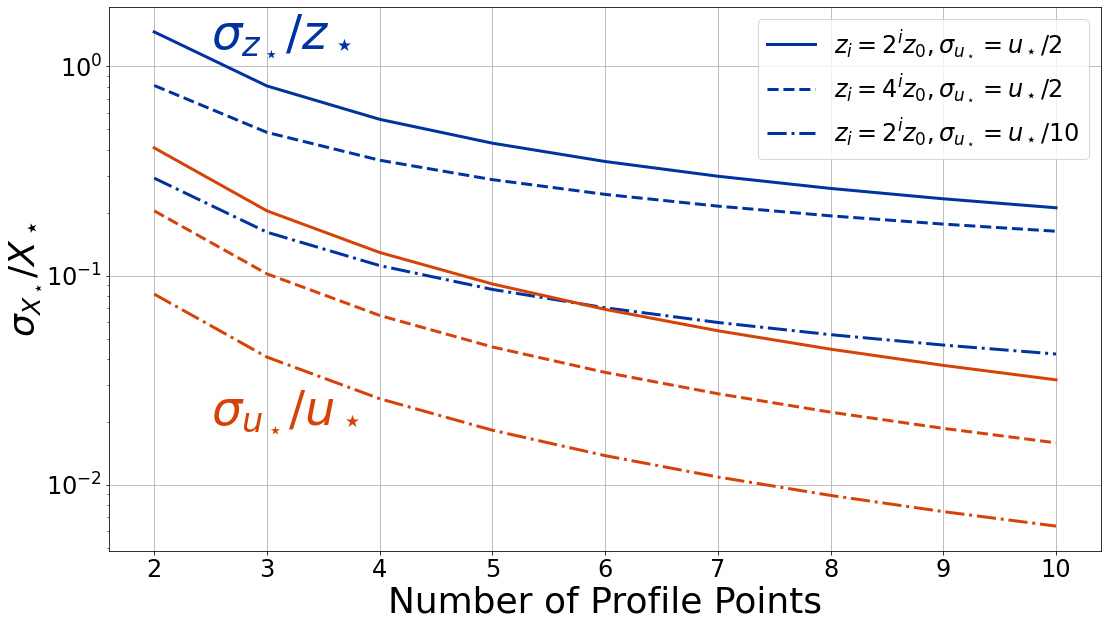

In [55]:
N = np.arange(2, 11)
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(111)
                   
ax1.plot(N, calc_analytic_fractional_zstar_uncertainty(N, sigma_over_ustar=0.5), 
         color=BoiseState_blue, lw=3, 
         label=r'$z_i = 2^i z_0, \sigma_{u_\star} = u_\star/2$')
ax1.plot(N, calc_analytic_fractional_zstar_uncertainty(N, delta_x=np.log(4), sigma_over_ustar=0.5), 
         color=BoiseState_blue, lw=3, ls='--', 
         label=r'$z_i = 4^i z_0, \sigma_{u_\star} = u_\star/2$')

ax1.plot(N, calc_analytic_fractional_zstar_uncertainty(N, sigma_over_ustar=0.1), 
         color=BoiseState_blue, lw=3, ls='-.',
         label=r'$z_i = 2^i z_0, \sigma_{u_\star} = u_\star/10$')

ax1.plot(N, calc_analytic_fractional_ustar_uncertainty(N, sigma_over_ustar=0.5), 
         color=BoiseState_orange, lw=3)
ax1.plot(N, calc_analytic_fractional_ustar_uncertainty(N, delta_x=np.log(4), sigma_over_ustar=0.5), 
         color=BoiseState_orange, lw=3, ls='--')
ax1.plot(N, calc_analytic_fractional_ustar_uncertainty(N, sigma_over_ustar=0.1), 
         color=BoiseState_orange, lw=3, ls='-.')

ax1.legend(loc='upper right', fontsize=24)
ax1.grid(True)
ax1.set_xlabel('Number of Profile Points', fontsize=36)
ax1.set_ylabel(r'$\sigma_{X_\star}/X_\star$', fontsize=36)
ax1.tick_params(labelsize=24)

ax1.set_yscale("log")

ax1.text(2.5, 1.25, r'$\sigma_{z_\star}/z_\star$', color=BoiseState_blue, fontsize=48)
ax1.text(2.5, 0.02, r'$\sigma_{u_\star}/u_\star$', color=BoiseState_orange, fontsize=48)

# fig.savefig("fractional_uncertainties.jpg", dpi=300, bbox_inches="tight");